# IHLT Lab 2

Lab developed by:
- Niklas Long Schiefelbein
- Oriol Miró López-Feliu


**Exercice description:**

1. Read all pairs of sentences of the SMTeuroparl files of test set within the evaluation framework of the project.

2. Compute their similarities by considering words and Jaccard distance. A distance should be obtained for each pair of sentences (a vector of similarities).

3. Compare the previous results with gold standard by giving the pearson correlation between them. Only a global measure should be obtained from all previous distances.

4. Justify the answer.

**Notebook Distribution:**

We'll first load the data, perform a small EDA and proceed with the exercice. On the latter, we will experiment with different approaches (tokenization, data cleaning) and finally analyse what works best, providing a final justification.

## Imports

In [1]:
# base
import pandas as pd
import nltk

# distance
from nltk.metrics import jaccard_distance
from scipy.stats import pearsonr

# tokenizers
nltk.download('punkt')
import spacy
nlp = spacy.load('en_core_web_sm')

# cleaning
nltk.download('stopwords')
from string import punctuation

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load base data
dt = pd.read_csv('/content/drive/MyDrive/MAI_IHLT_LAB/data/test-gold/STS.input.SMTeuroparl.txt',sep='\t',header=None)

# include the gs labels
dt['gs'] = pd.read_csv('/content/drive/MyDrive/MAI_IHLT_LAB/data/test-gold/STS.gs.SMTeuroparl.txt',sep='\t',header=None)

## Small EDA

In [4]:
print(f"shape:          {dt.shape}")
print(f"columns:        {dt.columns}")
print(f"head:           {dt.head()}")
print(f"duplicate rows: {dt[dt.duplicated()].shape[0]}")

# wow! 142 duplicate rows - bette remove them:
# PD: When we talked about duplicate removal with our classmates, many disagreed; we believe it is good
#   practice to not overrepresent characteristics of data (e.g. 10 duplicates of a specific case makes it weight more than it should).
#   If this is not OK to do, please let us know, thanks :)
dt.drop_duplicates(inplace=True)

shape:          (459, 3)
columns:        Index([0, 1, 'gs'], dtype='object')
head:                                                              0  \
0  The leaders have now been given a new chance a...   
1  Amendment No 7 proposes certain changes in the...   
2  Let me remind you that our allies include ferv...   
3        The vote will take place today at 5.30 p.m.   
4  The fishermen are inactive, tired and disappoi...   

                                                   1    gs  
0  The leaders benefit aujourd' hui of a new luck...  4.50  
1  Amendment No 7 is proposing certain changes in...  5.00  
2  I would like to remind you that among our alli...  4.25  
3                 The vote will take place at 5.30pm  4.50  
4  The fishermen are inactive, tired and disappoi...  5.00  
duplicate rows: 142


## Useful functions

In [5]:
def compute_pearson_correlation(dt, column_name):
    return pearsonr(dt['gs'], dt[column_name])[0]

def plot_pearson_comparison(correlations, labels):

    # color palette (so we dont have to provide it, as variable nº of inputs)
    colors = sns.color_palette(n_colors=len(labels))

    # plot bar graph
    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, correlations, color=colors)

    plt.ylabel("Pearson's Correlation")
    plt.title("Comparison of Pearson's Correlation for Different Methods")
    plt.ylim(0, 1)  # Adjust the range based on your data

    # number above each bar (clarity)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom')

    # show plot
    plt.show()

def print_sentences_diff(df, title):
    print(title)
    for index, row in df.iterrows():
        print(f"Sentence 1: {row[0]}")
        print(f"Sentence 2: {row[1]}")
        print(f"Difference (diff): {row['diff_abs']}\n")


## Approaches:
For our approaches we will experiment with the following
1. Different tokenization methods
2. Effect of homogenising casing
3. Effect of removing useless words (stopwords, punctuation signs)

### Testing tokenizer

In [6]:
# naive (splitting at spaces)
dt['jd_naive'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set(row[0].split()),
        set(row[1].split())
    )) * 5, axis=1
)

# punkt
dt['jd_punkt'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set(nltk.word_tokenize(row[0])),
        set(nltk.word_tokenize(row[1]))
    )) * 5, axis=1
)

# spaCy
dt['jd_spacy'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set([token.text for token in nlp(row[0])]),
        set([token.text for token in nlp(row[1])])
    )) * 5, axis=1
)


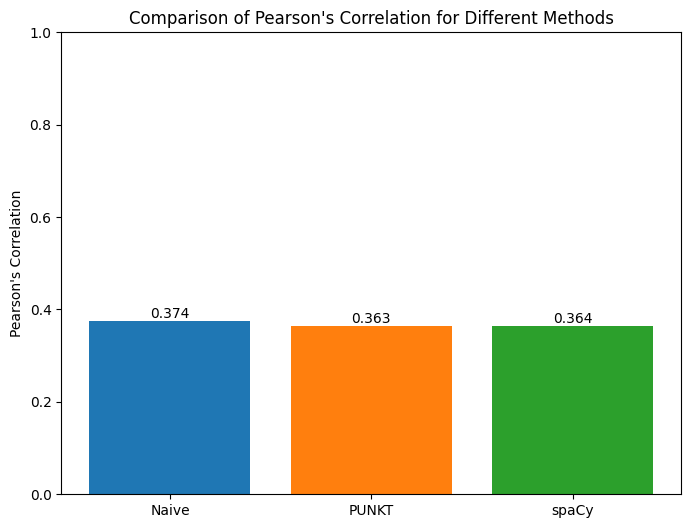

In [7]:
# correlations
pearson_corr_naive  = compute_pearson_correlation(dt, 'jd_naive')
pearson_corr_punkt  = compute_pearson_correlation(dt, 'jd_punkt')
pearson_corr_spacy  = compute_pearson_correlation(dt, 'jd_spacy')

# plot
correlations = [pearson_corr_naive, pearson_corr_punkt, pearson_corr_spacy]
tokenizers   = ['Naive', 'PUNKT', 'spaCy']
plot_pearson_comparison(correlations, tokenizers)

**Partial analysis:**

Barely any difference across tokenizers - likely due to similarity between their algorithms. Surprisingly, the naive method worked best, so we'll continue using it going forward. Might not be the best decision for all datasets though.

### Homogenising casing

Given lowercase and uppercase are simmetrical, we will only compare the original vs lowercasing every word.

PD: Technically we already have the result for no casing - naive's last result, but we'll compute it again so the experiment is complete on its own.

In [8]:
# not capitalised
dt['jd_not_cased'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set(row[0].split()),
        set(row[1].split())
    )) * 5, axis=1
)

# capitalised
dt['jd_cased'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set(row[0].lower().split()),
        set(row[1].lower().split())
    )) * 5, axis=1
)

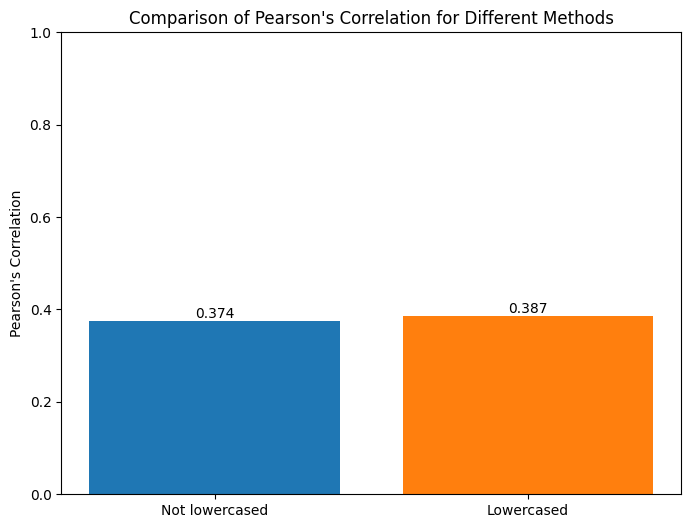

In [9]:
# correlations
pearson_corr_not_cased  = compute_pearson_correlation(dt, 'jd_not_cased')
pearson_corr_cased      = compute_pearson_correlation(dt, 'jd_cased')

# plot
correlations = [pearson_corr_not_cased, pearson_corr_cased]
tokenizers   = ['Not lowercased', 'Lowercased']
plot_pearson_comparison(correlations, tokenizers)

**Partial Analysis:**

Performance seems to slightly improve with casing! Likely due to some words - such as Hi and hi - now being correctly recognised as the same one in Jaccard's formula.

Going forward we will lowercase all words.

### Removing no information words

Finally we will test whether removing "useless words" - such as stopwords and punctuation signs - helps.

As a note, we will not use the isalpha() method because that removes all non-alphabetic symbol - but there could be numbers that we want to keep! Instead we'll check whether it's an nltk stopword and if it's a punctuation sign.

Another important design decision: because we split "naively" (at spaces), sentences like "Hello, good morning" are split into ["Hello,", "good", "morning"], therefore to remove punctuation we must do so within each token (word).

In [10]:
stop_words = set(nltk.corpus.stopwords.words('english'))

# not cleaning
dt['jd_not_cleaned'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set(row[0].lower().split()),
        set(row[1].lower().split())
    )) * 5, axis=1
)

# cleaning stopwords and punctuation

# this is to remove punctuation from the words ("hello," -> "hello"), see https://www.w3schools.com/Python/ref_string_maketrans.asp
translator = str.maketrans('', '', punctuation)

dt['jd_cleaned'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set([word.translate(translator).lower() for word in row[0].split()
             if word.translate(translator).lower() not in stop_words and word.translate(translator)]),
        set([word.translate(translator).lower() for word in row[1].split()
             if word.translate(translator).lower() not in stop_words and word.translate(translator)])
    )) * 5, axis=1
)

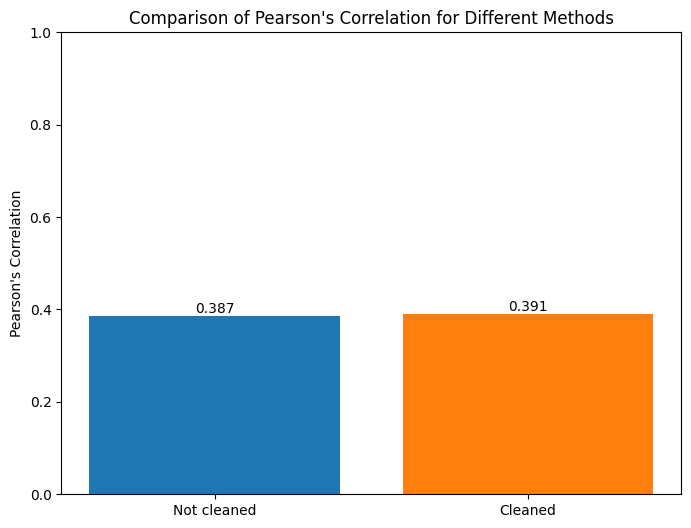

In [11]:
# correlations
pearson_corr_not_cleaned  = compute_pearson_correlation(dt, 'jd_not_cleaned')
pearson_corr_cleaned      = compute_pearson_correlation(dt, 'jd_cleaned')

# plot
correlations = [pearson_corr_not_cleaned, pearson_corr_cleaned]
tokenizers   = ['Not cleaned', 'Cleaned']
plot_pearson_comparison(correlations, tokenizers)

**Partial Analysis:**

As expected, performance improves. This is because you can rephrase a sentence to include a comma, keeping the same meaning.

## Final Analysis

Our final pearson correlation is a mere 0.391, obtained by tokenising naively, lowercassing all words and cleaning stopwords and punctuation signs. We will now look at a few examples to understand the underperformance, as well as some plots:

In [12]:
# compute "final" distance (for cleanliness and completeness)
dt['jd_final'] = dt.apply(
    lambda row: (1 - jaccard_distance(
        set([word.translate(translator).lower() for word in row[0].split()
             if word.translate(translator).lower() not in stop_words and word.translate(translator)]),
        set([word.translate(translator).lower() for word in row[1].split()
             if word.translate(translator).lower() not in stop_words and word.translate(translator)])
    )) * 5, axis=1
)

In [15]:
# We will now visualize some rows where our approach worked, and some where it faled.
# It worked when the difference between 'gs' and 'jd_final' is small, and it did not when the opposite is true.

# calc difference
dt['diff_abs'] = (dt['gs'] - dt['jd_final']).abs()

# sort (smallest: worked, largest: did not work)
smallest_diff = dt.nsmallest(10, 'diff_abs')
largest_diff  = dt.nlargest (10, 'diff_abs')

print_sentences_diff(smallest_diff, "10 rows with the smallest difference:")

print("\n\n-----------------------------------------\n\n")

print_sentences_diff(largest_diff, "10 rows with the largest difference:")

10 rows with the smallest difference:
Sentence 1: The fishermen are inactive, tired and disappointed.
Sentence 2: The fishermen are inactive, tired and disappointed.
Difference (diff): 0.0

Sentence 1: Tunisia
Sentence 2: Tunisia
Difference (diff): 0.0

Sentence 1: Amendment No 7 proposes certain changes in the references to paragraphs.
Sentence 2: Amendment No 7 proposes changes to certain paragraphs references.
Difference (diff): 0.0

Sentence 1: Thank you, Commissioner.
Sentence 2: Thank you, Commissioner.
Difference (diff): 0.0

Sentence 1: (Parliament adopted the legislative resolution)
Sentence 2: (Parliament adopted the legislative resolution)
Difference (diff): 0.0

Sentence 1: Amendment No 7 proposes certain changes in the references to paragraphs.
Sentence 2: Amendment No 7 proposes certain changes in the references to paragraphs.
Difference (diff): 0.0

Sentence 1: The fishermen are inactive, tired and disappointed.
Sentence 2: The fishermen inactive, are tired and disappoin

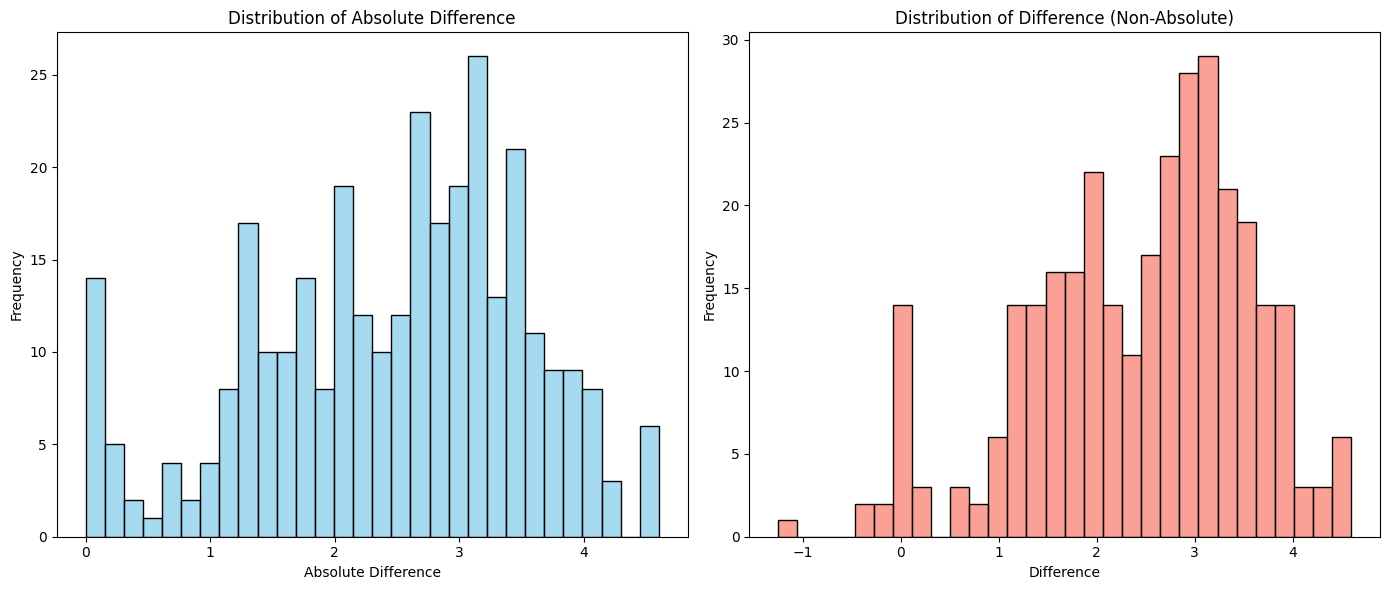

In [14]:
# we'd also like to see whether we overshoot or undershoot with our ratings:
dt['diff'] = dt['gs'] - dt['jd_final']

# two plots (absolute and no absolut)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# abs
sns.histplot(dt['diff_abs'], bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Absolute Difference')
axes[0].set_xlabel('Absolute Difference')
axes[0].set_ylabel('Frequency')

# no abs
sns.histplot(dt['diff'], bins=30, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Difference (Non-Absolute)')
axes[1].set_xlabel('Difference')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The above right plot indicates that we tend to underestimate the similarity between words (as most frequently, ('gs'-'real') is positive)

In conclusion, Jaccard's distance underperforms because the metric only works well when the exact same words are used. It fails to recognise synonims, etcetera. In other words, it only accounts for _form_, and lacks any sense of _meaning_.

